# Financial and Accounting Analytics of Stock Returns During Market Shock of Early 2022 - Eunjin Jeong

link: https://colab.research.google.com/drive/1gxwfUNbVJdsnVG89F0kClLt7cK4XaBQV?usp=sharing

# Introduction

## Project Background

For the first quarter of 2022, all major stock benchmarks dropped significantly, ranging from a 4.6% decline for the S&P 500 to as much as 9% for the Nasdaq Composite.

This vast market impact came from the combination of various economic issues including supply chain, inflation, and Russia's invasion.

The biggest reason is the high inflation in the U.S. This led the Federal Reserve to raise interest rates after the near-zero rate at the onset of the Covid-19 pandemic. Meanwhile, Russia’s invasion of Ukraine threatened the business investment and consumer spending.

Therefore, in this project, I would like to analyze what financial and accounting factors affected the stock returns during market shock of early 2022.


## Problem statement

In this project, I would like to analyze what financial and accounting factors affected the stock returns during the market shock of early 2022, particulary using risk exposures, financial ratios, and industry indicators.

## Methodology
* I used 5 datasets: Early 2022 stock return data, Monthly stock return data from 2017 to 2021, Financal data of companies from finacial statement, Fama-French factur returns data, and industry iindicator data.
* Using datsets, I derived risk exposures, financial ratios, and industry indicator using ggroup.
* Finally, I conducted linear regression to analyze stock return during early 2022.

## Import libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore
import math
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
# For clean code output
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Stock return data
* This dataset contains 1,886 observations for 3 columns: Ticker (the stock's ticker symbol), Name (the name of each company), and RetTYD (the year-to-date stock return of each company from January 1, 2022 to April 14, 2022)
* I dropped 'Name' column and renamed Ticker as 'TICKER' for merging with other datasets. 
* Final shape: 1886 observations, 2 columns

In [ ]:
# Load dataset
stock = pd.read_csv("/content/ProjectTickers.csv")

In [ ]:
# Change column name
stock.rename(columns={'Ticker':'TICKER'}, inplace=True)

In [ ]:
# Drop Name column
stock.drop(stock.columns[1], axis=1, inplace=True)

In [ ]:
stock.shape

(1886, 2)

In [ ]:
stock.head()

,TICKER,RetYTD
0,A,-0.2080
1,AA,0.4731
2,AAL,0.0579
3,AAN,-0.1327
4,AAON,-0.3456


## Monthly stock return data: 17-21

### Basic information 
* This dataset is for stock return data from January 2017 to December 2022(60 months) of 1886 companies, collected from CRSP on the WRDS database. 
* This dataset consists of 114715 observations and 4 columns.
  * PERMNO/TICKER: unique identifiers of companies
  * RET: monthly stock return data
  * date: datatdate
* There are **1924 unique values in TICKER**, which is larger than 'ProjectTickers' dataset(1886) - One possible reason is that Ticker symbol of some companies have changed, so that WRDS dataset collected data from more than 1886 Tickers.


In [ ]:
returns = pd.read_csv("/content/Project-2017-21-Returns.csv")

In [ ]:
returns.head(3)

,PERMNO,date,TICKER,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836
2,10026,20170331,JJSF,0.016293


In [ ]:
# 1924 tickers
returns.TICKER.nunique()

1924

In [ ]:
returns.PERMNO.nunique()

1920

In [ ]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


In [ ]:
returns.isna().sum()

PERMNO     0
date       0
TICKER    62
RET       15
dtype: int64

### Handling missing values
* There are 62 missing values in TICKER and 15 missing values in RET.
* I will go over how I handled missing values and the reason why I dropped those in this section.

#### Missing values in 'RET' column
* I decided to drop missing values in RET (15 observations)
* It is because RET is eventually target variable in the final regression. Filling missing values in RET result in incorrect/biased final regression model results.

In [ ]:
# Dropping missing values in RET column
returns.dropna(axis=0, subset=['RET'], inplace=True)

In [ ]:
returns.isna().sum()

PERMNO     0
date       0
TICKER    58
RET        0
dtype: int64

#### Missing values in TICKER column
* The remaning missing values in 'TICKER' is all from same company, whos PERMNO is 92683. Based on Permno-Ticker matching table, those data is from company 'EVO'. 
* Since RET in these rows are 'B', which is not numerical value and appropriate as RET value. 
* Therefore I decided to drop these rows because anyway I can't use these rows for predictiog RET in the Risk exposures regression

In [ ]:
returns[returns.isnull().any(axis=1)].PERMNO.nunique()

1

In [ ]:
# All missing values in Ticker are from same company: PERMNO==92683
returns[returns.isnull().any(axis=1)].PERMNO.unique()

array([92683])

In [ ]:
returns[returns.PERMNO==92683].transpose()

,111355,111356,111357,111358,111359,111360,111361,111362,111363,111364,...,111405,111406,111407,111408,111409,111410,111411,111412,111413,111414
PERMNO,92683,92683,92683,92683,92683,92683,92683,92683,92683,92683,...,92683,92683,92683,92683,92683,92683,92683,92683,92683,92683
date,20170131,20170228,20170331,20170428,20170531,20170630,20170731,20170831,20170929,20171031,...,20210331,20210430,20210528,20210630,20210730,20210831,20210930,20211029,20211130,20211231
TICKER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVO,EVO
RET,B,B,B,B,B,B,B,B,B,B,...,B,B,B,B,B,B,B,B,C,0.007637


In [ ]:
returns.dropna(axis=0, subset=['TICKER'], inplace=True)

In [ ]:
returns.isna().sum()

PERMNO    0
date      0
TICKER    0
RET       0
dtype: int64

### String values in RET
* Drop string values in RET
* Convert datatype to float
* Final format: 114629 observations, 4 columns

In [ ]:
returns[returns.RET.str.isalpha()]

,PERMNO,date,TICKER,RET
33195,16497,20170131,CNDT,C
33255,16498,20170131,HGV,C
33315,16499,20170131,PK,C
33555,16543,20170131,VREX,C
33675,16554,20170131,JELD,C
33795,16560,20170131,REVG,C
33855,16562,20170131,ANAB,C
33915,16570,20170131,JNCE,C
34096,16692,20170531,GDI,C
34813,18420,20190329,FOXA,C


In [ ]:
returns = returns[returns.RET.isin(['C'])==False]

In [ ]:
returns["RET"] = pd.to_numeric(returns["RET"], errors='raise')

In [ ]:
# 114629 entries, 4 columns
returns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114629 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  114629 non-null  int64  
 1   date    114629 non-null  int64  
 2   TICKER  114629 non-null  object 
 3   RET     114629 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ MB


In [ ]:
# Copy dataset for future use
ret = returns.copy()

## Financial dataset

* This dataset is collected from from Compustat on the WRDS database. 
* This dataset indicates financial report data for the year 2021 for each of the stocks with 1886 Tickers
* After dropping some unneccesary columns, I got 1886 observations and 23 columns.
* There are missing values in this dataset, so I will handle those in the financla ratio section, before creating ratios.

In [ ]:
finan = pd.read_csv("/content/Project-2021-Financials.csv")

In [ ]:
# Drop unneccesary column
finan.drop(columns=['gvkey','indfmt','consol','popsrc','datafmt','curcd','costat','dvt'],inplace=True)

In [ ]:
# Change column name
finan.rename(columns={'tic':'TICKER'}, inplace=True)

In [ ]:
finan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datadate  1886 non-null   int64  
 1   fyear     1886 non-null   int64  
 2   TICKER    1886 non-null   object 
 3   act       1431 non-null   float64
 4   at        1886 non-null   float64
 5   ceq       1886 non-null   float64
 6   ch        1857 non-null   float64
 7   che       1886 non-null   float64
 8   chech     1885 non-null   float64
 9   cogs      1886 non-null   float64
 10  csho      1886 non-null   float64
 11  dt        1649 non-null   float64
 12  ebit      1886 non-null   float64
 13  invt      1852 non-null   float64
 14  lct       1431 non-null   float64
 15  lt        1881 non-null   float64
 16  ni        1886 non-null   float64
 17  re        1883 non-null   float64
 18  revt      1886 non-null   float64
 19  sale      1886 non-null   float64
 20  seq       1886 non-null   floa

In [ ]:
finan.head(3)

,datadate,fyear,TICKER,act,at,ceq,ch,che,chech,cogs,...,invt,lct,lt,ni,re,revt,sale,seq,prcc_c,mkvalt
0,20210531,2020,AIR,937.0,1539.700,974.4,51.800,60.200,-364.500,1364.60,...,591.000,336.800,565.300,35.80,723.400,1651.400,1651.400,974.4,36.22,1476.9063
1,20211231,2021,AAL,17336.0,66467.000,-7340.0,273.000,13421.000,9.000,27969.00,...,1795.000,19006.000,73807.000,-1993.00,-14580.000,29882.000,29882.000,-7340.0,17.96,11633.1949
2,20211231,2021,PNW,1551.1,22003.222,5906.2,9.969,9.969,-49.999,2347.65,...,367.167,1756.869,15981.762,618.72,3209.858,3803.835,3803.835,5906.2,70.59,7971.5169


In [ ]:
# copy dataset for future use
finance=finan.copy()

## Fama-French factor returns data
* This dataset contains Fama-French factor returns data, which will be used to determine risk exposures
* 60 observations(60 month), 5  columns. No missing values

In [ ]:
fffactors = pd.read_csv("/content/FF-Factors-2017-2021.csv")

In [ ]:
fffactors.head(3)

,dateff,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003


In [ ]:
fffactors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


In [ ]:
fffactors.isna().sum()

dateff    0
mktrf     0
smb       0
hml       0
rf        0
dtype: int64

In [ ]:
# Rename column name 
fffactors.rename(columns={'dateff':'date'}, inplace=True)

## Industry indicator data
* Industry identifier data for the year 2021 for each of the stocks with 1886 tickers, downloaded from Compustat on the WRDS(based on datadate)
* I collected gsector, ggroup, gind, gsubind. For the final regression model, I will use 'ggroup'
* 1886 observations and 15 columns. No missing values.

In [ ]:
industry = pd.read_csv("/content/Project-2021-Sector.csv")

In [ ]:
industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1886 non-null   int64 
 1   datadate  1886 non-null   int64 
 2   fyear     1886 non-null   int64 
 3   indfmt    1886 non-null   object
 4   consol    1886 non-null   object
 5   popsrc    1886 non-null   object
 6   datafmt   1886 non-null   object
 7   tic       1886 non-null   object
 8   curcd     1886 non-null   object
 9   fyr       1886 non-null   int64 
 10  costat    1886 non-null   object
 11  ggroup    1886 non-null   int64 
 12  gind      1886 non-null   int64 
 13  gsector   1886 non-null   int64 
 14  gsubind   1886 non-null   int64 
dtypes: int64(8), object(7)
memory usage: 221.1+ KB


In [ ]:
industry.shape

(1886, 15)

In [ ]:
industry.isna().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
fyr         0
costat      0
ggroup      0
gind        0
gsector     0
gsubind     0
dtype: int64

In [ ]:
# Drop unneccesary column
industry.drop(columns=['gvkey','indfmt','consol','popsrc','datafmt','curcd','costat'],inplace=True)

In [ ]:
# Change column name
industry.rename(columns={'tic':'TICKER'}, inplace=True)

In [ ]:
industry.head(3)

,datadate,fyear,TICKER,fyr,ggroup,gind,gsector,gsubind
0,20210531,2020,AIR,5,2010,201010,20,20101010
1,20211231,2021,AAL,12,2030,203020,20,20302010
2,20211231,2021,PNW,12,5510,551010,55,55101010


# Determine Risk Exposures

## Run for-loop to calculate risk exposures
* for 1923 unique Tickers
* output: 1923 entries, 7 columns

In [ ]:
# Get unique ticker values from return data
company_list = list(ret["TICKER"].unique())

In [ ]:
len(company_list)

1923

In [ ]:
ticker = []
rsquared = []
adjrsquared = []
alpha = []
comkrf = []
cosmb = []
cohml = []

for company in company_list:
  company_data = ret[ret["TICKER"] == company]
  
  # Merge stock return data of each company with FF risk factor data 
  merge_data = pd.merge(company_data, fffactors, on='date', how='inner')
  
  # Set up dependent variable, independent variable
  y = merge_data["RET"] - merge_data["rf"]
  X = merge_data[['mktrf' , 'smb' , 'hml']]

  # Add a constant
  X = sm.add_constant(X)

  # Build regression model
  model = sm.OLS(y, X).fit()

  # Extract results and add into lists
  ticker.append(company)
  rsquared.append(round(model.rsquared,3))
  adjrsquared.append(round(model.rsquared_adj,3))
  comkrf.append(round(model.params.mktrf,3))
  cosmb.append(round(model.params.smb,3))
  cohml.append(round(model.params.hml,3))
  try:
    alpha.append(round(model.params.const,3))
  except AttributeError:
    alpha.append(np.NaN)

In [ ]:
# Create dictionary for dataframe
output = {'TICKER':ticker,
          'R-squared':rsquared,
          'Adj. R-squared':adjrsquared,
          'const':alpha,
          'mktrf':comkrf,
          'smb':cosmb,
          'hml':cohml}

In [ ]:
# Convert dictionary to dataframe
df_output = pd.DataFrame(output)  

In [ ]:
df_output.head()

,TICKER,R-squared,Adj. R-squared,const,mktrf,smb,hml
0,JJSF,0.318,0.282,0.003,0.453,0.357,0.524
1,PLXS,0.534,0.509,0.002,0.956,0.230,0.598
2,ORCL,0.417,0.386,0.004,0.839,-0.587,0.016
3,MSFT,0.638,0.618,0.014,0.936,-0.330,-0.401
4,TROW,0.606,0.585,0.005,1.121,0.009,0.145


In [ ]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923 entries, 0 to 1922
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TICKER          1923 non-null   object 
 1   R-squared       1923 non-null   float64
 2   Adj. R-squared  1919 non-null   float64
 3   const           1920 non-null   float64
 4   mktrf           1923 non-null   float64
 5   smb             1923 non-null   float64
 6   hml             1923 non-null   float64
dtypes: float64(6), object(1)
memory usage: 105.3+ KB


### Missing values in output

* Missing values in Adjusted r squared
 * There are missing values in AdjR2 even though there isn't missing values in R2. It's because denominator is N-p-1 in adjR2 formula. When 𝑝=𝑛−1 the adjusted 𝑅2 is undefined, and in fact the adjustment isn't valid when 𝑝≥𝑛−1. Here, p is 3, which are independent variables.
 * For example, for 'CHMT', the number of observation(3) is same as the number of independent variable(3)
* Missing values in Constant
 * For PRZM, IQNT, EVO, the number of observation data is only one, so they can't produce constant.
* Since we are going to use only 'mktrf', 'smb', 'hml', there are no missing values. Therefore, no need to handle missing values in AdjR2 and constant.

In [ ]:
df_output.isna().sum()

TICKER            0
R-squared         0
Adj. R-squared    4
const             3
mktrf             0
smb               0
hml               0
dtype: int64

In [ ]:
df_output[df_output.isnull().any(axis=1)]

,TICKER,R-squared,Adj. R-squared,const,mktrf,smb,hml
732,CHMT,1.0,NaN,0.02,0.324,0.908,0.702
1487,PRZM,-inf,NaN,NaN,2.571,-1.497,-3.631
1848,IQNT,-inf,NaN,NaN,-0.020,0.011,0.028
1867,EVO,-inf,NaN,NaN,0.104,-0.053,0.108


In [ ]:
ret[ret.TICKER=='CHMT']

,PERMNO,date,TICKER,RET
43604,38420,20170131,CHMT,-0.003012
43605,38420,20170228,CHMT,0.001511
43606,38420,20170331,CHMT,0.007541


In [ ]:
ret[ret.TICKER=='IQNT']

,PERMNO,date,TICKER,RET
110273,92454,20170131,IQNT,-0.000873


In [ ]:
# Preserve 'mktrf', 'smb', 'hml' only
ff_exposure = df_output[['TICKER','mktrf', 'smb', 'hml']]

In [ ]:
# No missing values
ff_exposure.isna().sum()

TICKER    0
mktrf     0
smb       0
hml       0
dtype: int64

### Outliers in estimates
* Based on box plot, there are outliers in estimates.
* Extreme outilers might not reflect the reality. Therefore, I decided to winsorize it - only for those 1 or 2 extreme outliers.

In [ ]:
ff_exposure.describe()

,mktrf,smb,hml
count,1923.000000,1923.000000,1923.000000
mean,1.077842,0.633398,0.310722
std,0.800945,1.936321,0.815668
min,-6.677000,-64.645000,-16.406000
25%,0.719000,0.013000,-0.054000
50%,1.005000,0.504000,0.359000
75%,1.338500,1.024000,0.760500
max,22.009000,31.006000,5.919000


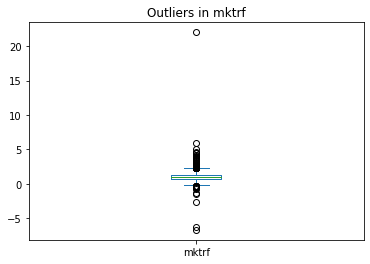

In [ ]:
ff_exposure['mktrf'].plot(kind='box')
plt.title("Outliers in mktrf") 
plt.show() 

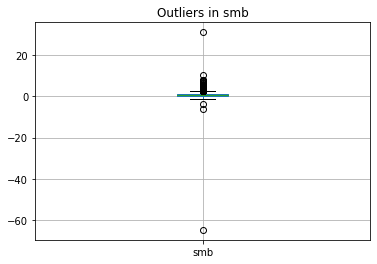

In [ ]:
ff_exposure.boxplot(column='smb')
plt.title("Outliers in smb") 
plt.show() 

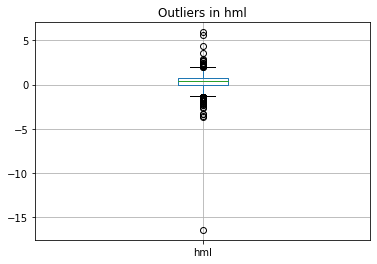

In [ ]:
ff_exposure.boxplot(column='hml')
plt.title("Outliers in hml") 
plt.show() 

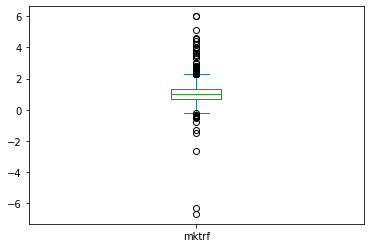

In [ ]:
# Winsorize mktrf == max(22)
ff_exposure['mktrf'] = winsorize(ff_exposure['mktrf'], (0, 0.001))
ff_exposure['mktrf'].plot(kind='box')

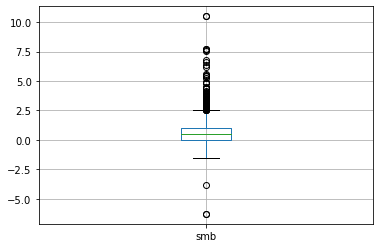

In [ ]:
# Winsorize min, max
ff_exposure['smb'] = winsorize(ff_exposure['smb'], (0.001, 0.001))
ff_exposure.boxplot(column='smb')

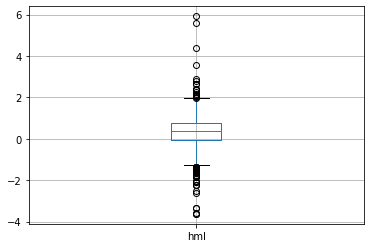

In [ ]:
# Winsorize min
ff_exposure['hml'] = winsorize(ff_exposure['hml'], (0.001, 0))
ff_exposure.boxplot(column='hml')

In [ ]:
ff_exposure.describe()

,mktrf,smb,hml
count,1923.000000,1923.000000,1923.000000
mean,1.069518,0.653085,0.317365
std,0.652773,1.061835,0.726609
min,-6.677000,-6.286000,-3.631000
25%,0.719000,0.013000,-0.054000
50%,1.005000,0.504000,0.359000
75%,1.338500,1.024000,0.760500
max,6.002000,10.505000,5.919000


## Save data
* Save the ticker symbol and the 3 exposure values
* TICKER, mktrf, smb, hml, date

In [ ]:
ff_exposure.to_csv('/content/FF-Exposures.csv')

# Calculate financial ratios

## Handle Missing values
* Missing values in act, ch, chech, dt, invt, lct, lt, re, mkvalt
* I decided not to use dt, re, chech, mkvalt for creating ratio, so I didn't handle missing values in these columns.
* Predict missing values using regressions
  1. Drop all missing values in every column before running a regression to avoid errors
  2. Add constant
  3. Fit the regression using relevant features
  4. Predict missing values and fill those in the original dataset.


In [ ]:
finance.isna().sum()

gvkey         0
datadate      0
fyear         0
indfmt        0
consol        0
popsrc        0
datafmt       0
tic           0
curcd         0
act         455
at            0
ceq           0
ch           29
che           0
chech         1
cogs          0
csho          0
dt          237
dvt          11
ebit          0
invt         34
lct         455
lt            5
ni            0
re            3
revt          0
sale          0
seq           0
costat        0
prcc_c        0
mkvalt       19
dtype: int64

### Current Assets - Total (act)

In [ ]:
# Drop all missing values in every column to avoid error
finance_act = finance.dropna(axis=0)
# Keep relevant features and add constant - for the features, they don't have missing values
X_act = sm.add_constant(finance_act[["at","sale","re","revt","che",'ni','cogs','csho']])
# Fit the ols model
ols_act = sm.OLS(finance_act['act'], X_act).fit()
print(ols_act.summary())

                            OLS Regression Results                            
Dep. Variable:                    act   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     990.0
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:38:00   Log-Likelihood:                -13270.
No. Observations:                1322   AIC:                         2.656e+04
Df Residuals:                    1314   BIC:                         2.660e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.1140    167.573      1.695      0.0

In [ ]:
# Keep rows with missing values in 'act'
act_nan = finance[finance.act.isnull()][["at","sale","re","revt","che",'ni','cogs','csho']]
# Add constant
act_nan = sm.add_constant(act_nan)
# Predict missing values 
act_pred = ols_act.predict(act_nan) 
# Replace missing values with predicted values
finance['act'].fillna(act_pred, inplace=True)

In [ ]:
# No more missing values in 'act'
finance['act'].isna().sum()

0

### Total liabilities (lt)

In [ ]:
finance_lt = finance.dropna(axis=0)
X_lt = sm.add_constant(finance_lt[["at","sale","re","revt","che",'ni','cogs','csho']])
ols_lt = sm.OLS(finance_lt['lt'], X_lt).fit()
print(ols_lt.summary())

                            OLS Regression Results                            
Dep. Variable:                     lt   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3897.
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:38:00   Log-Likelihood:                -13187.
No. Observations:                1322   AIC:                         2.639e+04
Df Residuals:                    1314   BIC:                         2.643e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -531.8137    157.366     -3.379      0.0

In [ ]:
lt_nan = finance[finance['lt'].isnull()][["at","sale","re","revt","che",'ni','cogs','csho']]
lt_nan = sm.add_constant(lt_nan)
lt_pred = ols_lt.predict(lt_nan) 
finance['lt'].fillna(lt_pred, inplace=True)

In [ ]:
finance['lt'].isna().sum()

0

### Current Liabilities - Total (lct)



In [ ]:
finance_lct = finance.dropna(axis=0)
X_lct = sm.add_constant(finance_lct[["lt","at","revt","sale","che",'csho','ceq','ebit']])
ols_lct = sm.OLS(finance_lct['lct'], X_lct).fit()
print(ols_lct.summary())

                            OLS Regression Results                            
Dep. Variable:                    lct   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     823.5
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:38:00   Log-Likelihood:                -13079.
No. Observations:                1322   AIC:                         2.617e+04
Df Residuals:                    1314   BIC:                         2.621e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -147.2603    144.044     -1.022      0.3

In [ ]:
lct_nan = finance[finance['lct'].isnull()][["lt","at","revt","sale","che",'csho','ceq','ebit']]
lct_nan = sm.add_constant(lct_nan)
lct_pred = ols_lct.predict(lct_nan) 
finance['lct'].fillna(lct_pred, inplace=True)

In [ ]:
finance['lct'].isna().sum()

0

### Inventories (invt)

In [ ]:
finance_invt = finance.dropna(axis=0)
X_invt = sm.add_constant(finance_invt[["at","lt",'act','lct',"che",'csho','seq','sale','ebit',"cogs",'mkvalt']])
ols_invt = sm.OLS(finance_invt['invt'], X_invt).fit()
print(ols_invt.summary())

                            OLS Regression Results                            
Dep. Variable:                   invt   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          3.25e-307
Time:                        16:38:00   Log-Likelihood:                -16317.
No. Observations:                1565   AIC:                         3.266e+04
Df Residuals:                    1553   BIC:                         3.272e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -439.6929    236.214     -1.861      0.0

In [ ]:
invt_nan = finance[finance['invt'].isnull()][["at","lt",'act','lct',"che",'csho','seq','sale','ebit',"cogs",'mkvalt']]
invt_nan = sm.add_constant(invt_nan)
invt_pred = ols_invt.predict(invt_nan) 
finance['invt'].fillna(invt_pred, inplace=True)

In [ ]:
finance['invt'].isna().sum()

0

### Cash

In [ ]:
finance_ch = finance.dropna(axis=0)
X_ch = sm.add_constant(finance_ch[["che","ni","ebit"]])
ols_ch = sm.OLS(finance_ch['ch'], X_ch).fit()
print(ols_ch.summary())

                            OLS Regression Results                            
Dep. Variable:                     ch   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     6293.
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:38:00   Log-Likelihood:                -14384.
No. Observations:                1593   AIC:                         2.878e+04
Df Residuals:                    1589   BIC:                         2.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.3931     52.716      5.091      0.0

In [ ]:
ch_nan = finance[finance['ch'].isnull()][["che","ni","ebit"]]
ch_nan = sm.add_constant(ch_nan)
ch_pred = ols_ch.predict(ch_nan) 
finance['ch'].fillna(ch_pred, inplace=True)

In [ ]:
finance['ch'].isna().sum()

0

## Create Financial ratios
Profitability ratio
* ROA = Ebit/Total assets = ebit/at
* ROE = ni/seq 
* Net profit margin = Ebit/Total sales
* Gross profit margin = (net sales - cost of goods sold)/ net sales

Market value ratios
* Market value = prcc_c * csho
* Book/Price = 1/[Price/Book] = CEQ/(PRCC_C * CSHO )
* E/P = 1/[P/E] = NI/ (PRCC_C * CSHO )
* EBIT/P = 1/[P/EBIT] = EBIT / (PRCC_C * CSHO )
* SALE/P = 1/[P/SALES] = SALE / (PRCC_C * CSHO )

Liquidity Ratios
* Quick ratio = (Current assets - Inventory)/Current liabilities
* Current ratio(working capital ratio) = Current assets/Current liabilities

Leverage ratios
* Debt to Equity(d/e) = Total liability/Total shareholders equity
* Cash ratio = (Cash (+cash equivalents)) / Current liabilities

Asset management ratios
* Asset turnover ratio = total sales/ total assets
* Inventory turnover ratio = Cost of goods sold /Average inventory

In [ ]:
# Profitability ratio
finance['ROA'] = finance['ebit']/finance['at']
finance['ROE'] = finance['ni']/finance['seq']
finance['net_profit_margin'] = finance['ebit'] / finance['sale']
finance['gross_profit_margin'] = (finance['sale']-finance['cogs'])/finance['sale']

# Market value ratio
finance['market_value']= finance['prcc_c']*finance['csho']  # for the market value calculation
finance['book/price'] = finance['ceq']/finance['market_value']
finance['e/p'] = finance['ni']/finance['market_value']
finance['ebit/p'] = finance['ebit']/finance['market_value']
finance['sale/p'] = finance['sale']/finance['market_value']

# Liquidity ratio
finance['quick_ratio'] = (finance['act']-finance['invt'])/finance['lct']
finance['current_ratio'] = finance['act']/finance['lct']

# Leverage ratio
finance['debt_to_equity'] = finance['lt']/finance['seq']
finance['cash_ratio'] = finance['ch']/finance['lct']

# Asset management ratio
finance['asset_turnover_ratio'] = finance['sale']/finance['at']
finance['inventory_turnover_ratio'] = finance['cogs']/finance['invt']

### Infinite values
* Looking at description of columns, there are infinite values in 'Inventory turnover ratio'
* There are 514 infinite values in 'inventory turnover ratio', accounting for 27% of the data
* I will squeeze infinite values, but eventually I found out that it's better not to use 'inventory turnover ratio'

In [ ]:
ratios = finance[['ROA','asset_turnover_ratio','net_profit_margin','gross_profit_margin','current_ratio','ROE','book/price','e/p','ebit/p','sale/p','quick_ratio','debt_to_equity','inventory_turnover_ratio','cash_ratio']]

In [ ]:
ratios.describe()

,ROA,asset_turnover_ratio,net_profit_margin,gross_profit_margin,current_ratio,ROE,book/price,e/p,ebit/p,sale/p,quick_ratio,debt_to_equity,inventory_turnover_ratio,cash_ratio
count,1886.000000,1886.000000,1886.000000,1869.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1872.000000,1886.000000
mean,0.047179,0.642005,-inf,-0.363488,2.263672,0.009034,0.422120,0.027009,0.060537,0.765998,1.871763,0.449923,NaN,0.856618
std,0.157399,0.616868,NaN,13.806636,11.525458,10.339557,0.424100,0.136354,0.130324,1.439880,11.407854,88.321469,NaN,2.434163
min,-1.420596,-0.009803,-inf,-498.116935,-350.979936,-364.326147,-2.056645,-1.891725,-1.334204,-0.087004,-350.979936,-3027.095238,-inf,-20.866277
25%,0.018602,0.185607,0.045584,0.246096,1.102038,0.024152,0.161112,0.008113,0.019641,0.176223,0.904813,0.753671,2.951400,0.102287
50%,0.053231,0.511923,0.127945,0.403095,1.599008,0.112438,0.337004,0.036704,0.056821,0.350729,1.253095,1.526501,7.359149,0.357098
75%,0.106175,0.900111,0.265951,0.651714,2.665410,0.212665,0.613868,0.076322,0.113822,0.814565,2.139778,3.415862,NaN,0.889904
max,1.908472,6.389003,1.220085,1.220085,156.897389,216.142857,7.547555,0.898517,0.974888,27.543662,156.897389,1346.744089,inf,43.626679


In [ ]:
ratio_list = ratios.columns
inf_dict={}
for ratio in ratio_list:
  infinite = np.isinf(ratios[ratio]).values.sum()
  inf_dict[ratio] = infinite

In [ ]:
inf_dict

{'ROA': 0,
 'ROE': 0,
 'asset_turnover_ratio': 0,
 'book/price': 0,
 'cash_ratio': 0,
 'current_ratio': 0,
 'debt_to_equity': 0,
 'e/p': 0,
 'ebit/p': 0,
 'gross_profit_margin': 0,
 'inventory_turnover_ratio': 514,
 'net_profit_margin': 17,
 'quick_ratio': 0,
 'sale/p': 0}

In [ ]:
# Replace infinite values to missing values to handle it
ratios.replace([np.inf, -np.inf], np.nan, inplace=True)

### Handle missing values in ratios
* 17 missing values in gross profit margin
* 14 missing values in iventory turnover ratio
* It is because both numerator and denominator are 0 for these values
* As we can see tables below, 'cogs', 'invt', 'sale' are 0 in this case
* Therefore, I will fill mean, instead of dropping missing values, to preserve other columns

In [ ]:
ratios.isna().sum()

ROA                           0
asset_turnover_ratio          0
net_profit_margin            17
gross_profit_margin          17
current_ratio                 0
ROE                           0
book/price                    0
e/p                           0
ebit/p                        0
sale/p                        0
quick_ratio                   0
debt_to_equity                0
inventory_turnover_ratio    528
cash_ratio                    0
dtype: int64

In [ ]:
avg_gross_profit_margin = ratios.gross_profit_margin.dropna().mean()
avg_inventory_turnover_ratio = ratios.inventory_turnover_ratio.dropna().mean()
avg_net_profit_margin = ratios.net_profit_margin.dropna().mean()
print(avg_gross_profit_margin)
print(avg_inventory_turnover_ratio)
print(avg_net_profit_margin)

-0.3634883626961332
18.036036903411357
-1.3743654237875533


In [ ]:
ratios[['gross_profit_margin']] = ratios[['gross_profit_margin']].fillna(avg_gross_profit_margin)
ratios[['inventory_turnover_ratio']] = ratios[['inventory_turnover_ratio']].fillna(avg_inventory_turnover_ratio)
ratios[['net_profit_margin']] = ratios[['net_profit_margin']].fillna(avg_net_profit_margin)

In [ ]:
ratios.isna().sum()

ROA                         0
asset_turnover_ratio        0
net_profit_margin           0
gross_profit_margin         0
current_ratio               0
ROE                         0
book/price                  0
e/p                         0
ebit/p                      0
sale/p                      0
quick_ratio                 0
debt_to_equity              0
inventory_turnover_ratio    0
cash_ratio                  0
dtype: int64

#### Closer look at the missing values
* Most of the missing values came from gsector 35; Health Care, ggroup 3520; Pharmaceuticals, Biotechnology & Life Sciences
* Usually pharmaceutical companies are huge R&D based and don't have a lot of stocks. Also, it might be the case that some pharmaceutical companies are in stage of R&D, and not selling products yet.

In [ ]:
finance[finance['inventory_turnover_ratio'].isna()][['cogs','invt','TICKER']].transpose()

,673,737,755,772,793,978,988,1025,1109,1252,1634,1766,1817,1864
cogs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
invt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TICKER,AGIO,CBAY,ALDX,NG,VKTX,KURA,AXSM,MDGL,KALV,SPPI,AVXL,OMER,ATOS,TNXP


In [ ]:
finance[finance['inventory_turnover_ratio'].isna()][['cogs','invt','TICKER']].TICKER.unique()

array(['AGIO', 'CBAY', 'ALDX', 'NG', 'VKTX', 'KURA', 'AXSM', 'MDGL',
       'KALV', 'SPPI', 'AVXL', 'OMER', 'ATOS', 'TNXP'], dtype=object)

In [ ]:
gics[gics.TICKER.isin(['AGIO', 'CBAY', 'ALDX', 'NG', 'VKTX', 'KURA', 'AXSM', 'MDGL',
       'KALV', 'SPPI', 'AVXL', 'OMER', 'ATOS', 'TNXP'])]

,TICKER,RetYTD,datadate,fyear,fyr,ggroup,gind,gsector,gsubind
50,AGIO,-0.1512,20211231,2021,12,3520,352010,35,35201010
74,ALDX,0.1400,20211231,2021,12,3520,352010,35,35201010
173,ATOS,-0.3063,20211231,2021,12,3520,352010,35,35201010
190,AVXL,-0.3599,20210930,2021,9,3520,352010,35,35201010
199,AXSM,-0.0244,20211231,2021,12,3520,352020,35,35202010
311,CBAY,-0.0828,20211231,2021,12,3520,352020,35,35202010
960,KALV,0.0854,20210430,2020,4,3520,352010,35,35201010
997,KURA,0.1521,20211231,2021,12,3520,352010,35,35201010
1095,MDGL,-0.0622,20211231,2021,12,3520,352010,35,35201010
1206,NG,0.1953,20211130,2021,11,1510,151040,15,15104030


In [ ]:
finance[finance['gross_profit_margin'].isna()][['cogs','sale','TICKER']].transpose()

,515,673,737,755,772,793,978,988,1025,1109,1252,1628,1634,1766,1788,1817,1864
cogs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TICKER,CVM,AGIO,CBAY,ALDX,NG,VKTX,KURA,AXSM,MDGL,KALV,SPPI,UEC,AVXL,OMER,AMPE,ATOS,TNXP


In [ ]:
finance[finance['gross_profit_margin'].isna()][['cogs','sale','TICKER']].TICKER.unique()

array(['CVM', 'AGIO', 'CBAY', 'ALDX', 'NG', 'VKTX', 'KURA', 'AXSM',
       'MDGL', 'KALV', 'SPPI', 'UEC', 'AVXL', 'OMER', 'AMPE', 'ATOS',
       'TNXP'], dtype=object)

In [ ]:
gics[gics.TICKER.isin(['CVM', 'AGIO', 'CBAY', 'ALDX', 'NG', 'VKTX', 'KURA', 'AXSM',
       'MDGL', 'KALV', 'SPPI', 'UEC', 'AVXL', 'OMER', 'AMPE', 'ATOS',
       'TNXP'])]

,TICKER,RetYTD,datadate,fyear,fyr,ggroup,gind,gsector,gsubind
50,AGIO,-0.1512,20211231,2021,12,3520,352010,35,35201010
74,ALDX,0.1400,20211231,2021,12,3520,352010,35,35201010
105,AMPE,-0.2982,20211231,2021,12,3520,352020,35,35202010
173,ATOS,-0.3063,20211231,2021,12,3520,352010,35,35201010
190,AVXL,-0.3599,20210930,2021,9,3520,352010,35,35201010
199,AXSM,-0.0244,20211231,2021,12,3520,352020,35,35202010
311,CBAY,-0.0828,20211231,2021,12,3520,352020,35,35202010
476,CVM,-0.5352,20210930,2021,9,3520,352010,35,35201010
960,KALV,0.0854,20210430,2020,4,3520,352010,35,35201010
997,KURA,0.1521,20211231,2021,12,3520,352010,35,35201010


In [ ]:
# Unique gsector: 35,15,10
gics[gics.TICKER.isin(['CVM', 'AGIO', 'CBAY', 'ALDX', 'NG', 'VKTX', 'KURA', 'AXSM',
       'MDGL', 'KALV', 'SPPI', 'UEC', 'AVXL', 'OMER', 'AMPE', 'ATOS',
       'TNXP'])].gsector.unique()

array([35, 15, 10])

### Handle outliers

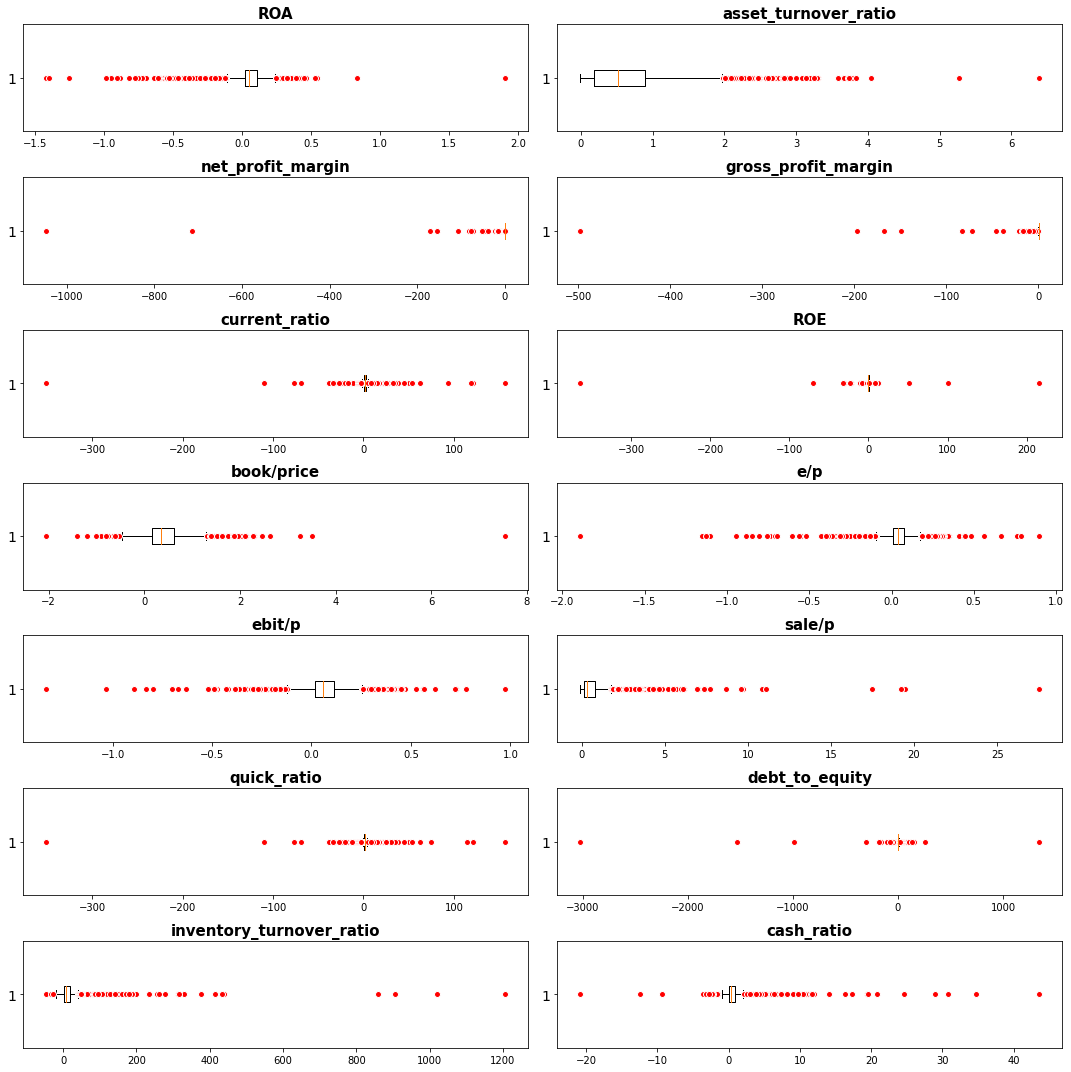

In [ ]:
#Creating boxplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
fig, axs = plt.subplots(7,2, figsize=(15,15))
for i, ax in enumerate(axs.flat):
    ax.boxplot(ratios.iloc[:,i], flierprops=red_circle, meanprops=mean_shape, vert = False)
    ax.set_title(ratios.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()

In [ ]:
# Winsorization
for ratio in ratios.columns:
    ratios[ratio] = winsorize(ratios[ratio], (0.01, 0.01))

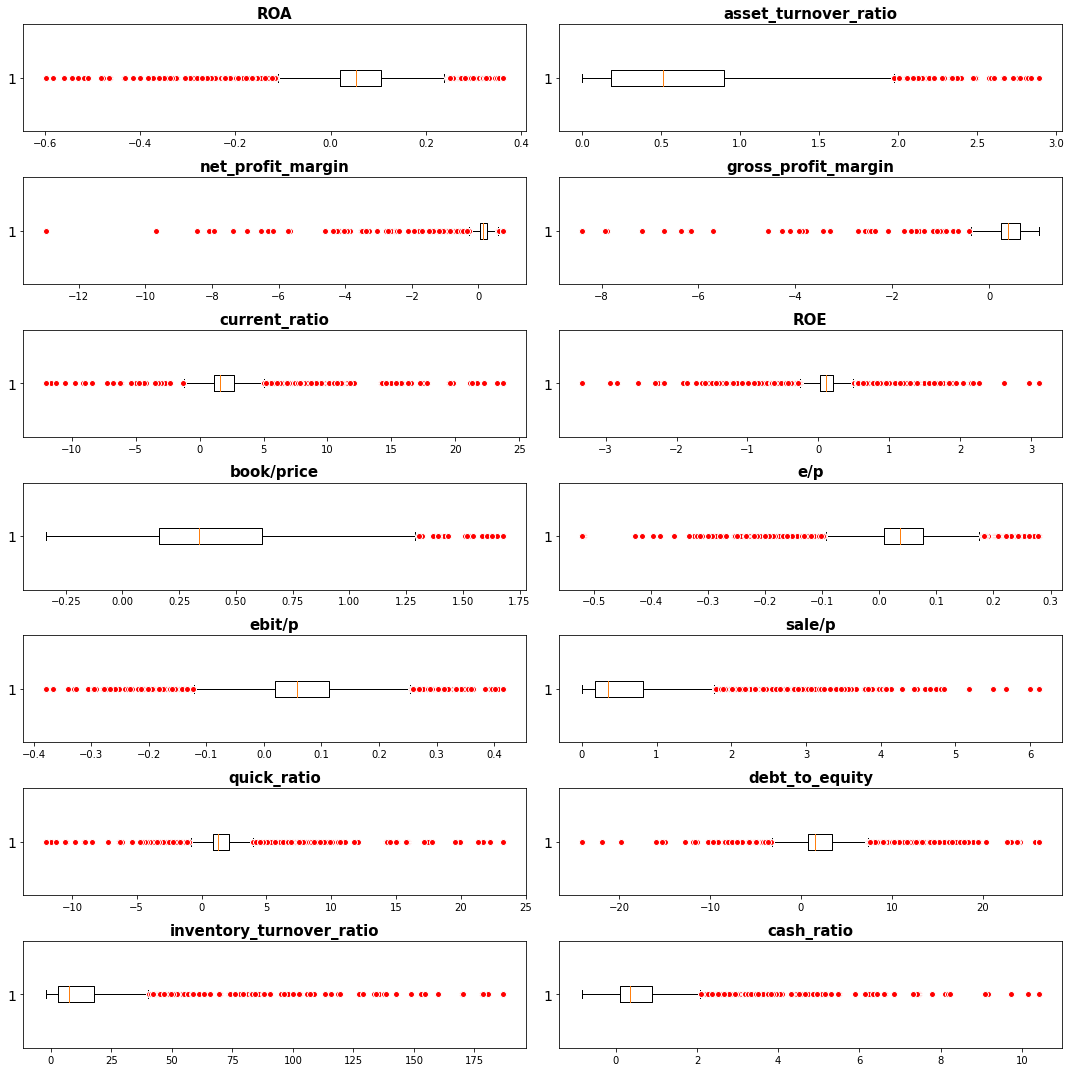

In [ ]:
#Creating boxplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
fig, axs = plt.subplots(7,2, figsize=(15,15))
for i, ax in enumerate(axs.flat):
    ax.boxplot(ratios.iloc[:,i], flierprops=red_circle, meanprops=mean_shape, vert = False)
    ax.set_title(ratios.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()

In [ ]:
ratios.describe()

,ROA,asset_turnover_ratio,net_profit_margin,gross_profit_margin,current_ratio,ROE,book/price,e/p,ebit/p,sale/p,quick_ratio,debt_to_equity,inventory_turnover_ratio,cash_ratio
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.048074,0.634149,-0.078588,0.298855,2.334855,0.094959,0.418517,0.028873,0.061671,0.715727,1.950548,2.624349,15.413509,0.803775
std,0.132698,0.576191,1.510211,1.097891,3.670970,0.620142,0.357616,0.104512,0.110981,0.984951,3.609828,5.322228,26.713753,1.490528
min,-0.597211,0.000132,-12.990348,-8.408805,-12.004311,-3.335815,-0.337273,-0.521213,-0.378436,0.000060,-12.004311,-24.094786,-2.000000,-0.836117
25%,0.018602,0.185607,0.045584,0.241888,1.102038,0.024152,0.161112,0.008113,0.019641,0.176223,0.904813,0.753671,2.988802,0.102287
50%,0.053231,0.511923,0.127945,0.399064,1.599008,0.112438,0.337004,0.036704,0.056821,0.350729,1.253095,1.526501,7.552105,0.357098
75%,0.106175,0.900111,0.265951,0.649018,2.665410,0.212665,0.613868,0.076322,0.113822,0.814565,2.139778,3.415862,18.036037,0.889904
max,0.361499,2.889664,0.742213,1.030189,23.722493,3.111111,1.677414,0.279700,0.415467,6.119348,23.259363,26.186977,186.843713,10.424628


### Correlation between ratios
* net profit margin and gross profit margin, e/p and ebit/p, quick ratio and cash ratio have relatively high correlation, over 0.7.

In [ ]:
corrmatrix = ratios.corr()

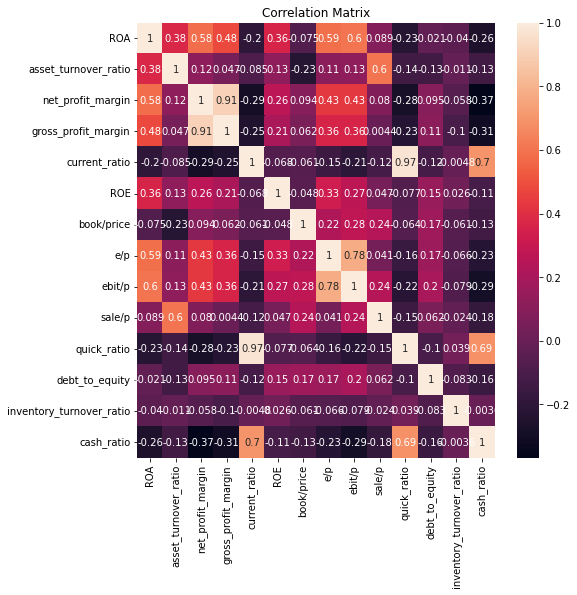

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmatrix, annot=True, ax=ax)
plt.title("Correlation Matrix")
plt.show()

## Merge dataset

In [ ]:
# Replace cleaned ratios to original finance dataset
finance[ratios.columns] = ratios

In [ ]:
# Change column name
finance.rename(columns={'tic':'TICKER'}, inplace=True)

In [ ]:
ratios_tic = finance[['TICKER','ROA','asset_turnover_ratio','net_profit_margin','gross_profit_margin','current_ratio','ROE','book/price','e/p','ebit/p','sale/p','quick_ratio','debt_to_equity','inventory_turnover_ratio','cash_ratio']]

In [ ]:
stock.head(3)

,TICKER,RetYTD
0,A,-0.2080
1,AA,0.4731
2,AAL,0.0579


In [ ]:
stock.shape

(1886, 3)

In [ ]:
ratios_tic.shape

(1886, 15)

In [ ]:
# Merge datasets
fin_ratios = pd.merge(stock,ratios_tic, on='TICKER', how='inner')

In [ ]:
fin_ratios.shape

(1886, 16)

In [ ]:
fin_ratios.head()

,TICKER,RetYTD,ROA,asset_turnover_ratio,net_profit_margin,gross_profit_margin,current_ratio,ROE,book/price,e/p,ebit/p,sale/p,quick_ratio,debt_to_equity,inventory_turnover_ratio,cash_ratio
0,A,-0.2080,0.131621,0.590285,0.222978,0.577148,2.224239,0.224531,0.111695,0.025079,0.029204,0.130970,1.738290,0.986454,3.219277,0.868852
1,AA,0.4731,0.138236,0.808785,0.170918,0.246791,1.559417,0.091824,0.425940,0.039111,0.189357,1.107882,0.952529,1.870933,4.679448,0.562830
2,AAL,0.0579,-0.082958,0.449576,-0.184526,0.064018,0.912133,0.271526,-0.337273,-0.171320,-0.378436,2.568684,0.817689,-10.055450,15.581616,0.014364
3,AAN,-0.1327,0.109513,1.280475,0.085525,0.947060,0.195881,0.153076,0.940491,0.143967,0.206699,2.416822,0.195881,1.006869,18.036037,0.235680
4,AAON,-0.3456,0.113249,0.822106,0.137754,0.309156,2.513369,0.126044,0.111730,0.014083,0.017648,0.128111,0.945752,0.394727,2.714827,0.032950


## Save dataset

In [ ]:
fin_ratios.to_csv('/content/Fin-Ratios.csv')

# Industry indicators

## Merge dataset
* stock dataset
* industry indicator dataset
* inner merge on 'TICKER'

In [ ]:
# Recall industry indicator dataset
industry.head(1)

,datadate,fyear,TICKER,fyr,ggroup,gind,gsector,gsubind
0,20210531,2020,AIR,5,2010,201010,20,20101010


In [ ]:
industry.shape

(1886, 8)

In [ ]:
stock.shape

(1886, 2)

In [ ]:
# Merge datasets
gics = pd.merge(stock,industry, on='TICKER', how='inner')

In [ ]:
gics.isna().sum()

TICKER      0
RetYTD      0
datadate    0
fyear       0
fyr         0
ggroup      0
gind        0
gsector     0
gsubind     0
dtype: int64

In [ ]:
gics.shape

(1886, 9)

In [ ]:
gics.head(3)

,TICKER,RetYTD,datadate,fyear,fyr,ggroup,gind,gsector,gsubind
0,A,-0.2080,20211031,2021,10,3520,352030,35,35203010
1,AA,0.4731,20211231,2021,12,1510,151040,15,15104010
2,AAL,0.0579,20211231,2021,12,2030,203020,20,20302010


## Save dataset

In [ ]:
# Save dataset
gics.to_csv("/content/Industry.csv")

# Run OLS explanatory for 4 categories

## Risk Regressions
* Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) + b3*ValueExposure(i) + e
* Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

### Merge dataset
* risk factors data
* montly stock return data
* Inner merge (ff_exposure: 1923 tickers, stock: 1886 tickers)

In [ ]:
ff_exposure.head(3)

,TICKER,mktrf,smb,hml
0,JJSF,0.453,0.357,0.524
1,PLXS,0.956,0.230,0.598
2,ORCL,0.839,-0.587,0.016


In [ ]:
# Merge datasets
ret_risk = pd.merge(stock,ff_exposure, on='TICKER', how='inner')

In [ ]:
ret_risk.shape

(1886, 5)

In [ ]:
ret_risk.isna().sum()

TICKER    0
RetYTD    0
mktrf     0
smb       0
hml       0
dtype: int64

In [ ]:
ret_risk.head(3)

,TICKER,RetYTD,mktrf,smb,hml
0,A,-0.2080,1.014,-0.254,-0.144
1,AA,0.4731,1.984,0.528,1.925
2,AAL,0.0579,1.316,0.613,1.248


### Regression interpretation
* Dependent variable: stock return of early 2022
* Independent variables: estimates(coefficients) of systemetic risk - coefficients of market factor(exposure to the broad market), coefficients of size factor(exposure to small stocks), and coefficients of value factor(exposure to value stocks). Note that these variables are not mktrf, smb, hml itself. These are **estimated betas** of each company by for-loop regression, which is the sensitivity of security’s returns to a particular systematic factor.
* Explanatory power of regression: R-squred is 0.094 and Adjusted R-squared is 0.092. 
 * R2 indicates how well the data “fits” the model, while AdjR2 is modified to adjust for the number of independent variables in the model, and is therefore considered the more conservative estimate.
 * Adjusted R Square measures the degree to which companies' stock return can be attributed to the independent variables.
 * Generally speaking, 0.092 adjusted R2 is considered low. 9.2% of the variance in the dependent variable is explained by the independent variables.

* Coefficients
 * Coefficient of **hml and smb are statistically significant** because p-value is less than 0.01 based on t-statistics.
 * Coefficients of **mktrf is not statistically significant** because p-value is greater than 0.05.
 * Incremental increase of the independent variable(mktrf, hml, smb respectively) result in a change in RetYTD by the amount of coefficient value. mktrf, hml affect positively on RetYTD, while smb affects negatively on RetYTD.
 * This shows how the sensitivity of a portfolio’s returns to changes in a systematic factor affects early 2022 stock return.

In [ ]:
# Risk regression
X_risk = sm.add_constant(ret_risk[['mktrf','smb','hml']])
model_risk = sm.OLS(ret_risk['RetYTD'], X_risk).fit()
print(model_risk.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     64.87
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           6.52e-40
Time:                        20:09:17   Log-Likelihood:                 79.078
No. Observations:                1886   AIC:                            -150.2
Df Residuals:                    1882   BIC:                            -128.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1004      0.011     -9.095      0.0

## Financial Characteristics
* I went over multiple regressions with different independent variable combinations.
* **Best model is Regression3, with 10 financial ratios** - ROA, asset_turnover_ratio, current_ratio, book/price, e/p, sale/p, quick_ratio, debt_to_equity, inventory_turnover_ratio, cash_ratio

* Explanatory power of regression: R-squred is 0.102 and Adjusted R-squared is 0.098 (based on regression3)
 * In general, 0.098 adjusted R2 is considered low. 9.8% of the variance in the dependent variable is explained by the independent variables. This result indicates **10 financial ratios explain 9.8% of the variance in the early 2022 stock return shock**.
 * However, the s**tock market is fundamentally unstable, dynamic, and adaptive, unlike other market, so that it's very hard to predict and explain stock return**. Therefore, it is considered low, but compared to risk regression, the explanatory power is a bit higher.

* Coefficients
 * Based on the best model(regression 3), coefficients of inventory_turnover_ratio and cash_ratio are not statistically significant because p-value is greater than 0.05. Other financial ratios are statistically significant, with p-value less than 0.05.
 * Incremental increase(one unit, which is %) of the each financial ratio result in a change in RetYTD by the amount of coefficient value. This shows how financial ratios affect stock return of early 2022.
 * ROA, book/price, sales/p, quick ratio, inventory_turnover_ratio affect positively on stock return, while other ratios affect negatively on stock return.

In [ ]:
fin_ratios.isna().sum()

TICKER                      0
RetYTD                      0
ROA                         0
asset_turnover_ratio        0
net_profit_margin           0
gross_profit_margin         0
current_ratio               0
ROE                         0
book/price                  0
e/p                         0
ebit/p                      0
sale/p                      0
quick_ratio                 0
debt_to_equity              0
inventory_turnover_ratio    0
cash_ratio                  0
dtype: int64

In [ ]:
fin_ratios.head(3)

,TICKER,RetYTD,ROA,asset_turnover_ratio,net_profit_margin,gross_profit_margin,current_ratio,ROE,book/price,e/p,ebit/p,sale/p,quick_ratio,debt_to_equity,inventory_turnover_ratio,cash_ratio
0,A,-0.2080,0.131621,0.590285,0.222978,0.577148,2.224239,0.224531,0.111695,0.025079,0.029204,0.130970,1.738290,0.986454,3.219277,0.868852
1,AA,0.4731,0.138236,0.808785,0.170918,0.246791,1.559417,0.091824,0.425940,0.039111,0.189357,1.107882,0.952529,1.870933,4.679448,0.562830
2,AAL,0.0579,-0.082958,0.449576,-0.184526,0.064018,0.912133,0.271526,-0.337273,-0.171320,-0.378436,2.568684,0.817689,-10.055450,15.581616,0.014364


In [ ]:
# Regression1
X1 = sm.add_constant(fin_ratios.drop(columns=['RetYTD','TICKER']))
model1 = sm.OLS(fin_ratios['RetYTD'], X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     15.26
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           1.35e-35
Time:                        18:40:03   Log-Likelihood:                 88.267
No. Observations:                1886   AIC:                            -146.5
Df Residuals:                    1871   BIC:                            -63.40
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# Regression2
X2 = sm.add_constant(fin_ratios.drop(columns=['TICKER','RetYTD','net_profit_margin','gross_profit_margin']))
model2 = sm.OLS(fin_ratios['RetYTD'], X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     17.81
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           8.28e-37
Time:                        18:43:21   Log-Likelihood:                 88.163
No. Observations:                1886   AIC:                            -150.3
Df Residuals:                    1873   BIC:                            -78.28
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Best model

In [ ]:
# Regression3
X3 = sm.add_constant(fin_ratios.drop(columns=['TICKER','RetYTD','gross_profit_margin','net_profit_margin','ROE','ebit/p']))
model3 = sm.OLS(fin_ratios['RetYTD'], X3).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     21.38
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           3.97e-38
Time:                        18:43:42   Log-Likelihood:                 88.127
No. Observations:                1886   AIC:                            -154.3
Df Residuals:                    1875   BIC:                            -93.29
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## Industry Dummies

* Ret(i) = a + coefficients*IndustryDummies + e
* Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

### Create Industry Indicators
* There are 24 unique ggroup.
* I dropped unnecessary columns and created dummy based on ggroup.

In [ ]:
gics.head(1)

,TICKER,RetYTD,datadate,fyear,fyr,ggroup,gind,gsector,gsubind
0,A,-0.208,20211031,2021,10,3520,352030,35,35203010


In [ ]:
# 24 unique ggroup
gics.ggroup.nunique()

24

In [ ]:
gics_ggroup = gics.drop(columns=['datadate', 'TICKER', 'fyear', 'fyr','gind','gsector','gsubind'])

In [ ]:
gics_ggroup = pd.get_dummies(gics_ggroup, columns=['ggroup'])

In [ ]:
# Add constant for the regression
gics_ggroup['constant'] = 1

In [ ]:
# created 24 dummy variables for 24 ggroup.
gics_ggroup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RetYTD       1886 non-null   float64
 1   ggroup_1010  1886 non-null   uint8  
 2   ggroup_1510  1886 non-null   uint8  
 3   ggroup_2010  1886 non-null   uint8  
 4   ggroup_2020  1886 non-null   uint8  
 5   ggroup_2030  1886 non-null   uint8  
 6   ggroup_2510  1886 non-null   uint8  
 7   ggroup_2520  1886 non-null   uint8  
 8   ggroup_2530  1886 non-null   uint8  
 9   ggroup_2550  1886 non-null   uint8  
 10  ggroup_3010  1886 non-null   uint8  
 11  ggroup_3020  1886 non-null   uint8  
 12  ggroup_3030  1886 non-null   uint8  
 13  ggroup_3510  1886 non-null   uint8  
 14  ggroup_3520  1886 non-null   uint8  
 15  ggroup_4010  1886 non-null   uint8  
 16  ggroup_4020  1886 non-null   uint8  
 17  ggroup_4030  1886 non-null   uint8  
 18  ggroup_4510  1886 non-null   uint8  
 19  ggroup

### Average RET by ggroup
* ggroup 1010 (energy) has the highest stock return, while ggroup 4530 (Semiconductors & Semiconductor Equipment) has the lowest stock return during early 2022.
 * Energy prices are rising due to an increase in demand and a decrease in supply, causing energy stock torise. Recovering from covid pandemic, global fuel demand surged due to increased travel and transportation.
The russian invasion of Ukraine increased uncertainty on energy supply, since Russia is the third-largest producer of liquid fuels and petroleum. Diminished OPEC output and supply chain disruptions in global trade also affected supply.
 * Slowing demand for computer chips is impacting the semiconductor industry. Covid pandemic cut demand for smartphones as well as smartphone market is maturing. In addition, high competition among semiconductor providers such as Samsung and TSMC is lowering price, and increasing supply.

In [ ]:
gics.groupby("ggroup")[['RetYTD']].mean().sort_values(by='RetYTD', ascending=False)

,RetYTD
ggroup,
1010,0.515035
3010,0.078312
1510,0.057846
5510,0.040759
3020,0.038780
5010,0.011838
4030,0.003779
2020,-0.035157
6010,-0.035826


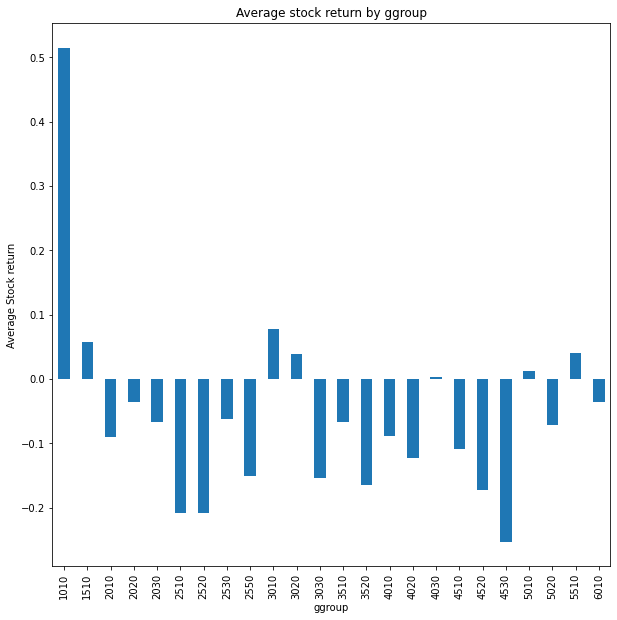

In [ ]:
dfg = gics.groupby(['ggroup'])['RetYTD'].mean()

dfg.plot(kind='bar', title='Average stock return by ggroup', ylabel='Average Stock return',
         xlabel='ggroup', figsize=(10, 10))

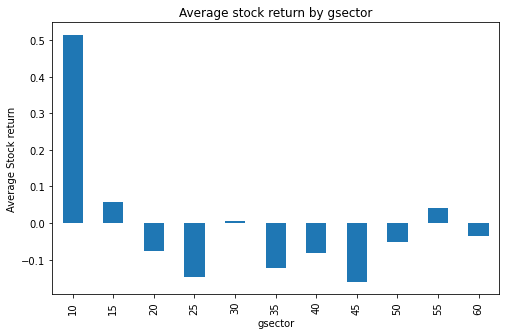

In [ ]:
# Additional graph - average stock return by gsector
dfg = gics.groupby(['gsector'])['RetYTD'].mean()

dfg.plot(kind='bar', title='Average stock return by gsector', ylabel='Average Stock return',
         xlabel='gsector', figsize=(8, 5))
plt.show()

### Regression 
* With constant and without one industry indicator - I decided to drop ggroup_1010

* **Explanatory power of regression** : R-squred is 0.326 and Adjusted R-squared is 0.317. Around 32% of the variance in the RetYTD is explained by the industry indicators - fixed effect. Usually 0.3 R2 is not considered high, but comparing with other regressions in this project, this value is significantly high.

* **Coefficients** in this regression show the relative averge stock return to CONSTANT which represents dropped industry(ggroup_1010: Energy). Therefore, the constant is the same as average stock return of  'ggroup_1010'. The average stock return in the other ggroups is calcuated by constant value plus coefficient of the ggroup. Coefficients are all statistically significant considering p-value in this regression. In addition, coefficients are negative execpt for costant because average stock return in ggroup_1010 is the highest.



In [ ]:
# keep constant. HOWEVER, must drop one industry indicator (let's choose "ggroup_1010")
x = gics_ggroup.drop(columns=['RetYTD','ggroup_1010'])
# Define y as a series
y = gics_ggroup['RetYTD']
print(sm.OLS(y, x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        22:28:40   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1510    -0.4572      0.031    -14.692      

### Additional regression
* Regression with all ggroup indicators and without constant 
* Coefficients in this regression indicate the average RetYTD for firms in early 2022 by industry. The cofficient values are same as average stock return for each industry. In terms of t statistics and p-value, estimates of ggroup_2020, ggroup_3010, ggroup_3020, ggroup_4030, ggroup_5010, and ggroup_5510 are not statistically significant because p-value is greater than 0.05, while others are statistically significant.
* R2 and AdjR2 are same as the first regression.

In [ ]:
# define x as a subset of original dataframe
x = gics_ggroup.drop(columns=['RetYTD','constant'])
# define y as a series
y = gics_ggroup['RetYTD']

# pass x as a dataframe, while pass y as a series
print(sm.OLS(y, x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        22:28:50   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.5150      0.023     22.140      

## Combined regressions

### Merge all dataset into the final dataframe

* Merge ret_risk, fin_ratios and gics
* 1886 observations, 43 columns
* No missing values

In [ ]:
# Merge fin_ratio and ret_risk
first_merge = pd.merge(fin_ratios,ret_risk, on=['TICKER','RetYTD'], how='inner')

In [ ]:
# Preparing gics dataset
# I used gics, not gics_ggroup to avoid errors
# Keep only necessary columns
fin_gics = gics[['TICKER','RetYTD','ggroup']]
# Create dummy
fin_gics = pd.get_dummies(fin_gics, columns=['ggroup'])

In [ ]:
# final merge
fin_merge = pd.merge(first_merge,fin_gics, on=['TICKER','RetYTD'], how='inner')

In [ ]:
# final shape
fin_merge.shape

(1886, 43)

In [ ]:
# No missing values
fin_merge.isna().sum().sum()

0

In [ ]:
# Final look of merged dataset
fin_merge.head()

,TICKER,RetYTD,ROA,asset_turnover_ratio,net_profit_margin,gross_profit_margin,current_ratio,ROE,book/price,e/p,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,-0.2080,0.131621,0.590285,0.222978,0.577148,2.224239,0.224531,0.111695,0.025079,...,0,0,0,0,0,0,0,0,0,0
1,AA,0.4731,0.138236,0.808785,0.170918,0.246791,1.559417,0.091824,0.425940,0.039111,...,0,0,0,0,0,0,0,0,0,0
2,AAL,0.0579,-0.082958,0.449576,-0.184526,0.064018,0.912133,0.271526,-0.337273,-0.171320,...,0,0,0,0,0,0,0,0,0,0
3,AAN,-0.1327,0.109513,1.280475,0.085525,0.947060,0.195881,0.153076,0.940491,0.143967,...,0,0,0,0,0,0,0,0,0,0
4,AAON,-0.3456,0.113249,0.822106,0.137754,0.309156,2.513369,0.126044,0.111730,0.014083,...,0,0,0,0,0,0,0,0,0,0


### Run combined regression

Final regression1

In [ ]:
X_fin1 = sm.add_constant(fin_merge.drop(columns=['ggroup_1010','TICKER','RetYTD']))
model_fin1 = sm.OLS(fin_merge['RetYTD'], X_fin1).fit()
print(model_fin1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     29.29
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          3.64e-166
Time:                        20:19:10   Log-Likelihood:                 449.95
No. Observations:                1886   AIC:                            -817.9
Df Residuals:                    1845   BIC:                            -590.7
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Final regression2
* Using 10 financial ratios

In [ ]:
X_fin2 = sm.add_constant(fin_merge.drop(columns=['ggroup_1010','TICKER','RetYTD','gross_profit_margin','net_profit_margin','ROE','ebit/p']))
model_fin2 = sm.OLS(fin_merge['RetYTD'], X_fin2).fit()
print(model_fin2.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     32.44
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          2.30e-168
Time:                        20:21:03   Log-Likelihood:                 448.00
No. Observations:                1886   AIC:                            -822.0
Df Residuals:                    1849   BIC:                            -616.9
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Final model interpretation (final regression1)


* Best final regression model is final regression1, with R-squared 0.388 and Adjusted R-squared 0.375
* Dependent variable: stock return of early 2022
* Independent variables: risk exposure estimates(sensitivity of security’s returns to a particular systematic factor), financial ratios, ggroup industry indicators.

* Explanatory power of regression
 * Adjusted R Square measures the degree to which companies' stock return can be attributed to the independent variables.
 * 37.5% of the variance in the stock return of early 2022 is explained by the independent variables.
 * Compared with all regressions performed in this project, the **explanatory power is the highest** in this final regression.


* Coefficients
 * Incremental increase of the independent variable result in a change in RetYTD by the amount of coefficient value. 
 * The positive/negative direction, the amount of values, and significance of coefficients shows how indepentdent variables affect stock return during early 2022.
 * Coefficients of net profit margin, gross_profit_margin,current_ratio, ROE, e/p, ebit/p, quick_ratio, debt_to_equity, inventory_turnover_ratio, cash_ratio, and mktrf are not statistically significant because p-value is higher than 0.05.

* Economic Interpretation
 * Among significant financial ratios, coefficient of **'ROA'** is notably high compared to others. This shows how well companies put assets to work to generate profits positively affected stock return. 
 * On the other hand, The asset turnover ratio, measuring the efficiency of a company's assets in generating sales, affected slightly negative to stock return. In general, retail or service sector companies have relatively small asset bases combined with high sales volume, leading to a high average asset turnover ratio. Firms in sectors like utilities or manufacturing tend to have large asset bases, translating to lower asset turnover. The result shows that incremental increase of asset turnover ratios decreased stock return on average.
 * Among significant market ratios, book value over price ald sales over price affected stock return positively.
 * Sensitivity of a portfolio’s returns to changes in a systematic factor also affected early 2022 stock return. Estimates of size factor(exposure to small stocks) affected negatively, while estimates of value factor(exposure to value stocks) affected positively on stock return.
 * Like mentioned in industry regression section, industry with the highest stock return was energy sector(ggroup 1010). Therefore, coefficients of all other industry indicators are negative, showing results relative to ggroup 1010.

# Conclusion

## Summary
* In conclusion, the best model is combined regression, with every variable generated. R-squared is 0.388 and the Adjusted R-squared is 0.375.
* Regression with industry indicators only performed second best, while financial characteristics regression and risk regression performed less than 0.1 adjusted R-squared. This shows that looking at fixed effect of industries explaines stock return relatively well. 
* Among industry sectors, the energy sector gained the highest average stock return, while the semiconductor industry gained the lowest return.
* It is also important to consider financial ratios, especially ROA, asset turnover ratio, book/price, and sales/price.



## Limitation & Recommendation
* **Data aspect** : To increase explanatory factor, it might be helpful to gather more data.
* **Deeper analysis on industry group** : It might be helpful to analyze risk exposures and financial ratios by industry. For example, some pharmaceutical companies had 0 slaes, cost of good solds, and inventories because pharmaceutical companies are largely R&D based. Therefore, understanding and knowledge of each industry is important to analyze financial factors.
* **Dealing with missing values** : 
When I filled missing values, I predicted missing values with other columns using linear regression. I would try other prediction models such as Neural network to improve accuracy.
Moreover, when I filled missing values in the financial ratios, I replaced it with the average values without missing values. I would try to calculate average ratio values in each industry, because most of the missing values came from specific industry such as pharmaceutical companies. I would happy to deep dive into the specific industry and see what happens and causes this issue.

* **Patterns in the stock market and explainability** : I leared that it is difficult to predict and find patterns in the stock market. It is because stock market is hugely competitive and efficient, so that every possible information is already included in the expectation. The stock market is fundamentally unstable, dynamic, and adaptive. Therefore, it is crucial to understand the characteritics of stock market, understand domain-based, industry knowledge, and explain the result of the model.

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!jupyter nbconvert --to html  '/content/drive/MyDrive/BA870/Project/Project_EunjinJeong.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/BA870/Project/Project_EunjinJeong.ipynb to html
[NbConvertApp] Writing 1020760 bytes to /content/drive/MyDrive/BA870/Project/Project_EunjinJeong.html
